In [1]:
#importing the required modules
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns

In [237]:
# Small adjustments to default style of plots, making sure it's readable and colorblind-friendly everywhere
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size' : 12.5,
                     'figure.figsize':(25,7)})

#### Using the provided csv file to link qids with meaningful names for speakers metadata

In [4]:
df_lookup = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2',compression = 'bz2',index_col='QID')

## 1. Create a function to retrieve all americans politicians

In [127]:
#drop NaNs in occupation
def get_polUS(df_speakers):
    df_speakers.dropna(axis=0,inplace=True,subset=['occupation','nationality'])
    assert df_speakers['occupation'].isna().sum() == 0
    assert df_speakers['nationality'].isna().sum() == 0
    
    pol_cond = df_speakers['occupation'].apply(lambda x : any(item in 'Q82955' for item in x)) 
    us_cond = df_speakers['nationality'].apply(lambda x : any(item in 'Q30' for item in x)) #Q142 for french 

    df_polUS = df_speakers.loc[us_cond & pol_cond]

    return df_polUS


# 2. Aggregation on speakers for an exploratory analysis on the american speakers

In [121]:
df_speakers =  pd.read_json(path+'Speakers_aggregation.json.bz2',compression = 'bz2',lines = True)

In [ ]:
# Drop the column related to classifications task ()
#df_speakers.drop(['0','1','fraction'],axis=1,inplace=True)

In [207]:
df_polUS_2 = get_polUS(df_speakers)
df_polUS_2.head(5)

label qid_unique     0    1  quotes_number  fraction  \
0      Barack Obama        Q76  1008  359           1367  0.262619   
1    Bernie Sanders    Q359442   723  268            991  0.270434   
3   Hillary Clinton      Q6294   645  245            890  0.275281   
4      Andrew Cuomo     Q11673   476  182            658  0.276596   
6  Elizabeth Warren    Q434706   378  179            557  0.321364   

                                             aliases            date_of_birth  \
0  [Barack Hussein Obama II, Barack Obama II, Bar...  [+1961-08-04T00:00:00Z]   
1                                  [Bernard Sanders]  [+1941-09-08T00:00:00Z]   
3  [Hillary Rodham Clinton, Hillary Rodham, Hilla...  [+1947-10-26T00:00:00Z]   
4                                [Andrew Mark Cuomo]  [+1957-12-06T00:00:00Z]   
6  [Elizabeth Ann Warren, Senator Warren, Elisabe...  [+1949-06-22T00:00:00Z]   

  nationality      gender   lastrevid  \
0       [Q30]  [Q6581097]  1395141963   
1       [Q30]  [Q6581097]  1392561607   
3       [Q30]  [Q6581072]  1393846565   
4       [Q30]  [Q6581097]  1393197828   
6       [Q30]  [Q6581072]  1394365746   

                              ethnic_group US_congress_bio_ID  \
0  [Q49085, Q6935055, Q12826303, Q6392846]            O000167   
1                                  [Q7325]            S000033   
3                                     None            C001041   
4                                [Q974693]               None   
6                                 [Q49078]            W000817   

                                          occupation  \
0    [Q82955, Q40348, Q15958642, Q28532974, Q372436]   
1  [Q82955, Q1930187, Q154549, Q1622272, Q36180, ...   
3  [Q82955, Q40348, Q193391, Q36180, Q18814623, Q...   
4                                   [Q40348, Q82955]   
6  [Q185351, Q82955, Q37226, Q1622272, Q40348, Q1...   

                                          party       academic_degree  \
0                                      [Q29552]  [Q1765120, Q1540185]   
1  [Q6542163, Q29552, Q327591, Q327591, Q29552]            [Q1765120]   
3                              [Q29552, Q29468]   [Q163727, Q1540185]   
4                                      [Q29552]            [Q1540185]   
6                                      [Q29552]   [Q163727, Q1540185]   

        id                                          candidacy  type  \
0      Q76  [Q3586671, Q45578, Q4226, Q4791768, Q17067714,...  item   
1  Q359442                                               None  item   
3    Q6294                                [Q699872, Q4791768]  item   
4   Q11673                             [Q22023432, Q65047185]  item   
6  Q434706                                        [Q28220813]  item   

                               religion  
0  [Q23540, Q1062789, Q960252, Q426316]  
1                               [Q9268]  
3                              [Q33203]  
4                               [Q1841]  
6                              [Q33203]

## Plot the distribution of colloquial language speaker in political party

[Text(0, 0.5, 'Average fraction of colloquial quotations')]

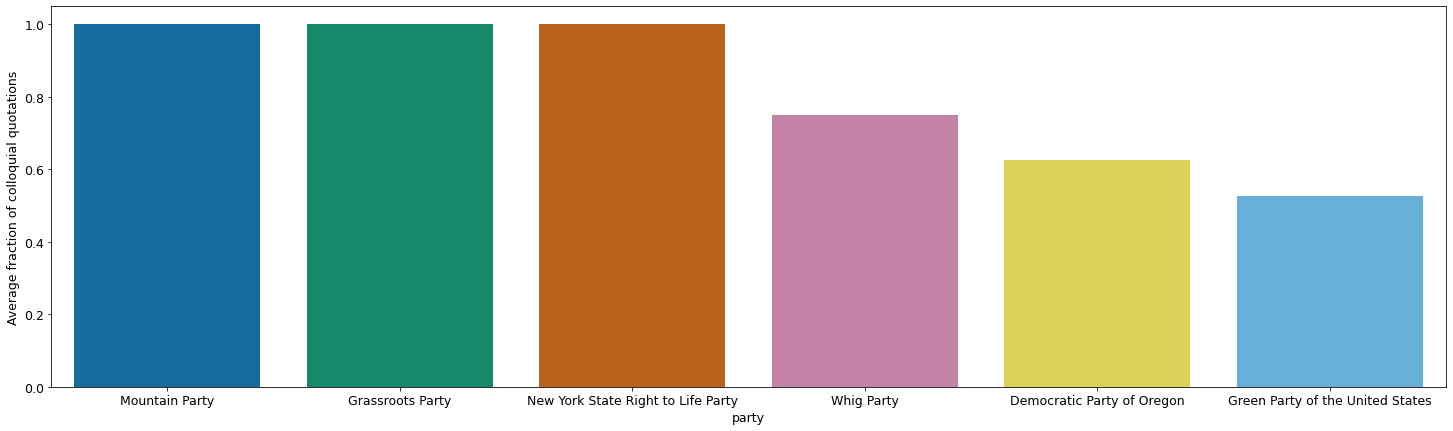

In [242]:

df_party=df_polUS_2.copy()
#Replace label column at the first place to see speakers names
df_party.dropna(axis = 0, subset=['party'], inplace=True)

#Drop all speakers that several parties
oneparty_cond = df_party['party'].apply(lambda x: len(x)==1)

#Transforma a list into one element
df_party['party'] = df_party['party'].apply(lambda x: x[0]) 

df_party = df_party[oneparty_cond]
#Not taking in account the occupation with fraction equals to 1 (correspond to speakers with not sufficient amount of quotations)
df_plot = df_party.groupby('party')['fraction'].mean() \
           .reset_index(name='mean_fraction')\
            .sort_values(['mean_fraction'], ascending=False)
#Not taking in account the occupation with fraction equals to 1 (correspond to speakers with not sufficient amount of quotations)

#df_plot = df_plot[df_plot['mean_fraction']!=1]
df_plot['party'] = df_plot['party'].apply(lambda x: df_lookup.loc[x]['Label'])

ax = sns.barplot(x='party', y="mean_fraction", data=df_plot[:6])
ax.set(ylabel='Average fraction of colloquial quotations')

In [243]:
print("There are {} parties in our dataset".format(len(df_plot)))

There are 62 parties in our dataset


# 3 Create the dataset for linear regression 

Keep only the quotes where the author is in df_us 

i. Import the quotes data 

In [110]:
#Jules: 
path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/'

df_quotes = pd.read_json(path+'Sample_classified_1Mio_v1.json.bz2',compression = 'bz2',lines = True)

In [96]:
df_quotes.head(10)

label qid_unique     0    1  quotes_number  fraction  \
0             Barack Obama        Q76  1008  359           1367  0.262619   
1           Bernie Sanders    Q359442   723  268            991  0.270434   
3          Hillary Clinton      Q6294   645  245            890  0.275281   
4             Andrew Cuomo     Q11673   476  182            658  0.276596   
5       Benjamin Netanyahu     Q43723   398  163            561  0.290553   
...                    ...        ...   ...  ...            ...       ...   
107354     Lucia Žitňanská   Q3090972     0    1              1  1.000000   
107385      Frank Habineza   Q3082639     0    1              1  1.000000   
107386  Jean-Michel Baylet   Q3082745     0    1              1  1.000000   
107391     François Bausch   Q3083923     1    0              1  0.000000   
107392     Abdoulie Bojang    Q308425     0    1              1  1.000000   

                                                  aliases  \
0       [Barack Hussein Obama II, Barack Obama II, Bar...   
1                                       [Bernard Sanders]   
3       [Hillary Rodham Clinton, Hillary Rodham, Hilla...   
4                                     [Andrew Mark Cuomo]   
5       [Binyamin Netanyahu, Bibi, Bibi Netanyahu, Ben...   
...                                                   ...   
107354                                  [Lucia Zitnanska]   
107385                                               None   
107386                                               None   
107391                                               None   
107392                                               None   

                  date_of_birth nationality      gender   lastrevid  \
0       [+1961-08-04T00:00:00Z]       [Q30]  [Q6581097]  1395141963   
1       [+1941-09-08T00:00:00Z]       [Q30]  [Q6581097]  1392561607   
3       [+1947-10-26T00:00:00Z]       [Q30]  [Q6581072]  1393846565   
4       [+1957-12-06T00:00:00Z]       [Q30]  [Q6581097]  1393197828   
5       [+1949-10-21T00:00:00Z]      [Q801]  [Q6581097]  1391756559   
...                         ...         ...         ...         ...   
107354  [+1964-06-03T00:00:00Z]      [Q214]  [Q6581072]  1394016134   
107385  [+1977-02-22T00:00:00Z]     [Q1037]  [Q6581097]  1360756260   
107386  [+1946-11-17T00:00:00Z]      [Q142]  [Q6581097]  1388626886   
107391  [+1956-10-16T00:00:00Z]       [Q32]  [Q6581097]  1322103995   
107392  [+1960-02-17T00:00:00Z]     [Q1005]  [Q6581097]  1312608148   

                                   ethnic_group US_congress_bio_ID  \
0       [Q49085, Q6935055, Q12826303, Q6392846]            O000167   
1                                       [Q7325]            S000033   
3                                          None            C001041   
4                                     [Q974693]               None   
5                                       [Q7325]               None   
...                                         ...                ...   
107354                                     None               None   
107385                                     None               None   
107386                                     None               None   
107391                                     None               None   
107392                                     None               None   

                                               occupation  \
0         [Q82955, Q40348, Q15958642, Q28532974, Q372436]   
1       [Q82955, Q1930187, Q154549, Q1622272, Q36180, ...   
3       [Q82955, Q40348, Q193391, Q36180, Q18814623, Q...   
4                                        [Q40348, Q82955]   
5       [Q82955, Q193391, Q372436, Q47064, Q15958642, ...   
...                                                   ...   
107354                                   [Q82955, Q40348]   
107385                                           [Q82955]   
107386   [Q1930187, Q82955, Q2961975, Q1420621, Q2824523]   
107391                                 [Q82955, Q7063944]  

ii. Import the speakers metadata

In [3]:
#Define the path for folder containing data
#TO BE MODIFIED ACCORDING HIS OWN FOLER containing data in local 
#Jules:
path = r'/Users/jules/kDrive/onedrive/Documents_Onedrive/EPFL/MA3/ADA/Project/Dataset/'
df_metadata = pd.read_parquet(path+'speaker_attributes.parquet')
#df_metadata.head()

In [133]:
df_meta_polUS = get_polUS(df_metadata)

In [135]:
# shift column 'Name' to first position
first_column = df_meta_polUS.pop('label')
# insert column using insert(position,column_name,first_column) function
df_meta_polUS.insert(0, 'label', first_column)

iii. Make the column "qid_speaker" unique 

In [146]:
#Choose the first QID that is associated with (to be improved)
df_quotes['qid_unique'] = df_quotes['qids'].apply(lambda x: x[0])

#Drop the useless columns 
col_useless = ['qids','probas','numOccurrences','phase']
df_quotes.drop(col_useless,axis=1,inplace=True)

KeyError: 'qids'

In [149]:
# shift column 'Name' to first position
first_column = df_quotes.pop('qid_unique')
# insert column using insert(position,column_name,first_column) function
df_quotes.insert(3, 'qid_unique', first_column)

In [150]:
df_quotes.loc[df_quotes['speaker']=='Donald Trump']

quoteID                                          quotation  \
387     2015-12-01-105669  the world is in turmoil and falling apart in s...   
391     2015-08-12-042086  I wonder if the Mexican government sent them h...   
479     2015-08-12-040836  I wanted to see the states decide. And I wante...   
2778    2015-09-26-026590                     I'm putting up my own funding,   
3062    2015-10-29-103496  That's what I can do for the country: We owe $...   
...                   ...                                                ...   
665681  2020-01-08-039229  In order to get elected, will start a war with...   
666854  2020-03-17-084961  Well, I think the 3.4% [ COVID-19 death rate ]...   
667007  2020-02-06-045994  If you believe that we should defend American ...   
667023  2020-01-03-047013  Over the years, Iran and its proxies have bomb...   
667654  2020-01-10-084449  They hit us with 16 missiles, and I said: `How...   

             speaker qid_unique                date  \
387     Donald Trump     Q22686 2015-12-01 16:58:57   
391     Donald Trump     Q22686 2015-08-12 22:25:37   
479     Donald Trump     Q22686 2015-08-12 20:58:28   
2778    Donald Trump     Q22686 2015-09-26 02:42:39   
3062    Donald Trump     Q22686 2015-10-29 02:41:38   
...              ...        ...                 ...   
665681  Donald Trump     Q22686 2020-01-08 01:21:52   
666854  Donald Trump     Q22686 2020-03-17 03:30:04   
667007  Donald Trump     Q22686 2020-02-06 07:48:20   
667023  Donald Trump     Q22686 2020-01-03 23:09:21   
667654  Donald Trump     Q22686 2020-01-10 16:49:26   

                                                     urls      p1      p2  \
387     [http://www.motherjones.com/blue-marble/2015/1...  0.7342  0.1509   
391     [http://www.huffingtonpost.com/lawrence-rosent...  0.7393  0.2607   
479     [http://breitbart.com/video/2015/08/12/trump-o...  0.9328  0.0672   
2778    [http://oudaily.com/news/donald-trump-refuses-...  0.6651  0.3349   
3062    [http://thestreet.com/story/13343003/1/donald-...  0.7893  0.2107   
...                                                   ...     ...     ...   
665681  [http://journalreview.com/stories/trump-campai...  0.6791  0.2360   
666854  [http://newshounds.us/outrageous_fox_quote_of_...  0.9110  0.0890   
667007  [https://www.thehindubusinessline.com/news/wor...  0.8965  0.0977   
667023  [https://www.washingtonexaminer.com/news/from-...  0.8229  0.1600   
667654  [http://www.abc.net.au/news/2020-01-10/trump-s...  0.8608  0.1392   

        delta_p  year  colloquial  
387      0.5833  2015           0  
391      0.4786  2015           0  
479      0.8656  2015           0  
2778     0.3302  2015           0  
3062     0.5786  2015           0  
...         ...   ...         ...  
665681   0.4431  2020           0  
666854   0.8220  2020           0  
667007   0.7988  2020           0  
667023   0.6629  2020           1  
667654   0.7216  2020           0  

[2075 rows x 11 columns]

iv. Merge the quotes with the speaker metadata

In [202]:
df_quotes_merged = df_quotes.merge(df_meta_polUS,how='inner',left_on='qid_unique', right_on='id')

In [205]:
df_quotes_merged.head()

quoteID                                          quotation  \
0  2015-08-19-053089  It's a rotten process, it's a defiled process,...   
1  2015-06-19-007527  By the very definition of the word, this proce...   
2  2015-08-15-072111  Why? If I was allowed to have both hands on th...   
3  2017-06-24-036281  It's not that hard of a reach to say this law ...   
4  2019-04-30-050786                   Is there a moat, a barge system?   

      speaker qid_unique                date  \
0  Evan Jenne   Q5415439 2015-08-19 22:03:58   
1  Evan Jenne   Q5415439 2015-06-19 01:08:41   
2  Evan Jenne   Q5415439 2015-08-15 16:21:15   
3  Evan Jenne   Q5415439 2017-06-24 10:30:23   
4  Evan Jenne   Q5415439 2019-04-30 00:00:00   

                                                urls      p1      p2  delta_p  \
0  [http://www.washingtontimes.com/news/2015/aug/...  0.8643  0.1327   0.7316   
1  [http://www.news4jax.com/politics/in-final-hou...  0.8724  0.1276   0.7448   
2  [http://web.tampabay.com/news/politics/statero...  0.8298  0.1702   0.6596   
3  [http://www2.tbo.com/news/florida/on-open-reco...  0.8540  0.1360   0.7180   
4  [http://floridapolitics.com/archives/295137-ho...  0.7546  0.2036   0.5510   

   year  ...   lastrevid ethnic_group US_congress_bio_ID occupation     party  \
0  2015  ...  1393420472         None               None   [Q82955]  [Q29552]   
1  2015  ...  1393420472         None               None   [Q82955]  [Q29552]   
2  2015  ...  1393420472         None               None   [Q82955]  [Q29552]   
3  2017  ...  1393420472         None               None   [Q82955]  [Q29552]   
4  2019  ...  1393420472         None               None   [Q82955]  [Q29552]   

  academic_degree        id candidacy  type religion  
0            None  Q5415439      None  item     None  
1            None  Q5415439      None  item     None  
2            None  Q5415439      None  item     None  
3            None  Q5415439      None  item     None  
4            None  Q5415439      None  item     None  

[5 rows x 26 columns]

v. Export the dataframe

In [204]:
df_quotes_merged.to_json(path+'polUS_quotes_speakers_merged.json.bz2',compression='bz2',lines=True,orient="records")